<a href="https://colab.research.google.com/github/JSJeong-me/KOSA-Big-Data_Vision/blob/main/Model/99_kaggle_credit_card_analysis_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,plot_roc_curve,accuracy_score
pd.set_option('display.max_columns',25)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Importing Dataset
data = pd.read_csv(r'./credit_cards_dataset.csv')
data.head(10)

In [ ]:
data.info()
#info shows that there is no null values and all the features are numeric

In [ ]:
data.describe(include='all') # Descriptive analysis

In [4]:
data.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'def_pay'},inplace=True) 
#rename few columns

# Exploratory Data Analysis

In [ ]:
plt.figure(figsize=(10,6))
data.groupby('def_pay')['AGE'].hist(legend=True)
plt.show()
#here we can see that, between age 20 to 45 most of the people will fall into..

In [ ]:
sns.distplot(data['AGE'])
plt.title('Age Distribution')

In [ ]:
sns.boxplot('def_pay','LIMIT_BAL',data=data)

In [ ]:
data[data['LIMIT_BAL']>700000].sort_values(ascending=False,by='LIMIT_BAL')

In [ ]:
data[data['LIMIT_BAL']>700000].value_counts().sum()

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.boxplot(x='SEX', y= 'AGE',data = data)
sns.stripplot(x='SEX', y= 'AGE',data = data,linewidth = 0.9)
plt.title ('Sex vs AGE')

plt.subplot(122)
ax = sns.countplot(x='EDUCATION',data = data,  order= data['EDUCATION'].value_counts().index)
plt.title ('EDUCATION')
labels = data['EDUCATION'].value_counts()
for i, v in enumerate(labels):
    ax.text(i,v+100,v, horizontalalignment='center')
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.boxplot(x='def_pay', y= 'AGE',data = data)
sns.stripplot(x='def_pay', y= 'AGE',data = data,linewidth = 0.9)
plt.title ('Age vs def_pay')

ax2=plt.subplot(1,2,2)
pay_edu = data.groupby('EDUCATION')['def_pay'].value_counts(normalize=True).unstack()
pay_edu = pay_edu.sort_values(ascending=False,by=1)
pay_edu.plot(kind='bar',stacked= True,color=["#3f3e6fd1", "#85c6a9"], ax = ax2)
plt.legend(loc=(1.04,0))
plt.title('Education vs def_pay')
plt.show()

In [7]:
# function for Multivariate analysis
# This method is used to show point estimates and confidence intervals using scatter plot graphs
def plotfig(df1,col11,col22,deft1):
    plt.figure(figsize=(16,6))

    plt.subplot(121)
    sns.pointplot(df1[col11], df1[deft1],hue = df1[col22])

    plt.subplot(122)
    sns.countplot(df1[col11], hue = df1[col22])
    plt.show() 


def varplot(df2, col1, col2, deft, bin=3, unique=10):
    df=df2.copy()
    if len(df[col1].unique())>unique:
        df[col1+'cut']= pd.qcut(df[col1],bin)
        if len(df[col2].unique())>unique:
            df[col2+'cut']= pd.qcut(df[col2],bin)
            return plotfig(df,col1+'cut',col2+'cut',deft)
        else:
            df[col2+'cut']= df[col2]
            return plotfig(df,col1+'cut',col2+'cut',deft)
    else:
        return plotfig(df,col1,col2,deft)

In [ ]:
varplot(data,'AGE','SEX','def_pay',3)

In [ ]:
varplot(data,'LIMIT_BAL','AGE','def_pay',3)

In [ ]:
# Univariate Analysis
df = data.drop('ID',1)
nuniq = df.nunique()
df = data[[col for col in df if nuniq[col]>1 and nuniq[col]<50]]
row, cols = df.shape
colnames = list(df)
graph_perrow = 5
graph_row = (cols+graph_perrow-1)/ graph_perrow
max_graph = 20
plt.figure(figsize=(graph_perrow*12,graph_row*8))
for i in range(min(cols,max_graph)):
    plt.subplot(graph_row,graph_perrow,i+1)
    coldf = df.iloc[:,i]
    if (not np.issubdtype(type(coldf),np.number)):
        sns.countplot(colnames[i],data= df, order= df[colnames[i]].value_counts().index)
    else:
        coldf.hist()
    plt.title(colnames[i])
plt.show()

In [ ]:
cont_var = df.select_dtypes(exclude='object').columns
nrow = (len(cont_var)+5-1)/5
plt.figure(figsize=(12*5,6*2))
for i,j in enumerate(cont_var):
    plt.subplot(nrow,5,i+1)
    sns.distplot(data[j])
plt.show()

In [ ]:
# from the above,we can see that we have maximum clients from 20-30 age group followed by 31-40. 
# Hence with increasing age group the number of clients that will default the payment next month is decreasing. 
# Hence we can see that Age is important feature to predict the default payment for next month.

In [ ]:
plt.subplots(figsize=(26,20))
corr = data.corr()
sns.heatmap(corr,annot=True)
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df= data.drop(['def_pay','ID'],1)
vif = pd.DataFrame()
vif['Features']= df.columns
vif['vif']= [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
vif

In [11]:
# From this heatmap and VIF we can see that there are some multicolinearity(values >10) in the data which we can handle
# simply doing feature engineering of some columns 

bill_tot = pd.DataFrame(data['BILL_AMT1']+data['BILL_AMT2']+data['BILL_AMT3']+data['BILL_AMT4']+data['BILL_AMT5']+data['BILL_AMT6'],columns=['bill_tot'])
pay_tot =pd.DataFrame(data['PAY_1']+data['PAY_2']+data['PAY_3']+data['PAY_4']+data['PAY_5']+data['PAY_6'],columns=['pay_tot'])
pay_amt_tot = pd.DataFrame(data['PAY_AMT1']+data['PAY_AMT2']+data['PAY_AMT3']+data['PAY_AMT4']+data['PAY_AMT5']+data['PAY_AMT6'],columns=['pay_amt_tot'])
frames=[bill_tot,pay_tot,pay_amt_tot,data['def_pay']]
tot = pd.concat(frames,axis=1)


In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(x='def_pay',y='pay_tot',data = tot)
sns.stripplot(x='def_pay',y='pay_tot',data = tot,linewidth=1)

plt.subplot(132)
sns.boxplot(x='def_pay', y='bill_tot',data=tot)
sns.stripplot(x='def_pay', y='bill_tot',data=tot,linewidth=1)

plt.subplot(133)
sns.boxplot(x='def_pay', y='pay_amt_tot',data=tot)
sns.stripplot(x='def_pay', y='pay_amt_tot',data=tot,linewidth=1)
plt.show()

In [ ]:
sns.pairplot(tot[['bill_tot','pay_amt_tot','pay_tot','def_pay']],hue='def_pay')
plt.show()

In [ ]:
sns.violinplot(x=tot['def_pay'], y= tot['bill_tot'])

In [13]:
tot.drop('def_pay',1,inplace=True)

In [14]:
data1 = pd.concat([data,tot],1)

In [ ]:
data1.groupby('def_pay')['EDUCATION'].hist(legend=True)
plt.show()

In [ ]:
data1.groupby('def_pay')['AGE'].hist()
plt.figure(figsize=(12,6))

In [15]:
# we know that the Bill_AMT is the most correlated column so using that we create a data
df= pd.concat([bill_tot,df],1)
df1 = df.drop(['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'],1)

In [ ]:
vif = pd.DataFrame()
vif['Features']= df1.columns
vif['vif']= [variance_inflation_factor(df1.values,i) for i in range(df1.shape[1])]
vif

In [ ]:
# above we can see that now our data doesnt have multicollinearty(no values >10)

In [17]:
data2 = df1.copy()

In [18]:
# using the above plot we can create age bins
age = [20,27,32,37,42,48,58,64,80]
lab = [8,7,6,5,4,3,2,1]
data2['AGE'] = pd.cut(data2['AGE'],bins= age,labels=lab)

In [ ]:
data2 =  pd.concat([data2,data['def_pay']],1)
data2

In [ ]:
data2.groupby('def_pay')['AGE'].hist()
plt.figure(figsize=(12,6))

In [ ]:
sns.countplot(data2['AGE'])

In [ ]:
data2.groupby('def_pay')['LIMIT_BAL'].hist(legend=True)
plt.show()

In [ ]:
data2.columns

# Model Creation
#### We know that we have a dataset where we have imbalance in the target variable
#### you get a pretty high accuracy just by predicting the majority class, but you fail to capture the minority class
#### which is most often the point of creating the model in the first place.
#### Hence we try to create more model to get the best results

In [20]:
x= data2.drop(['def_pay'],1)
y = data2['def_pay']
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=1)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [21]:
# Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.
# hence we are using Classification Report and Confusion Matrix
# function for accuracy and confusion matrix
def res(y_test_valid,y_train_valid):
    cm_log = confusion_matrix(y_test,y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    print(classification_report(y_test,y_test_valid))
    print('train_accuracy:',accuracy_score(y_train,y_train_valid))
    print('test_accuracy:',accuracy_score(y_test,y_test_valid))

# Logistic model

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4663
           1       0.72      0.22      0.34      1337

    accuracy                           0.81      6000
   macro avg       0.77      0.60      0.61      6000
weighted avg       0.79      0.81      0.76      6000

train_accuracy: 0.8107916666666667
test_accuracy: 0.8071666666666667


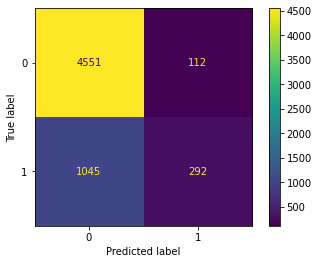

In [ ]:
log_model= LogisticRegression()
log_model.fit(x_train,y_train)
y_pred_log = log_model.predict(x_test)
y_pred_train = log_model.predict(x_train)
res(y_pred_log,y_pred_train)

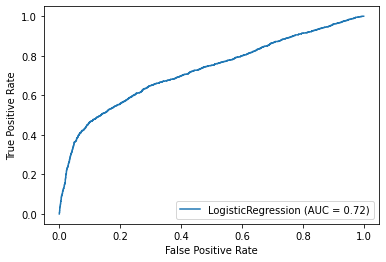

In [ ]:
plot_roc_curve(log_model,x_test,y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4663
           1       0.64      0.41      0.50      1337

    accuracy                           0.82      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.82      0.80      6000

train_accuracy: 0.8137083333333334
test_accuracy: 0.8158333333333333


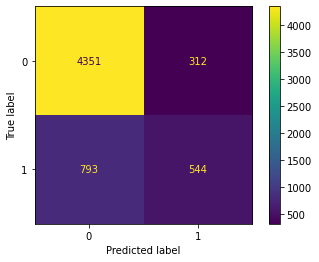

In [ ]:
# log model using Threshold
threshold = 0.36
y_log_prob =  log_model.predict_proba(x_test)
y_train_log_prob = log_model.predict_proba(x_train)
y_log_prob=y_log_prob[:,1]
y_train_log_prob= y_train_log_prob[:,1]
y_pred_log_prob = np.where(y_log_prob>threshold,1,0)
y_pred_log_prob_train = np.where(y_train_log_prob>threshold,1,0)
res(y_pred_log_prob,y_pred_log_prob_train)

# using Decision Tree model

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      4663
           1       0.37      0.40      0.38      1337

    accuracy                           0.71      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.72      0.71      0.72      6000

train_accuracy: 0.9977083333333333
test_accuracy: 0.7146666666666667


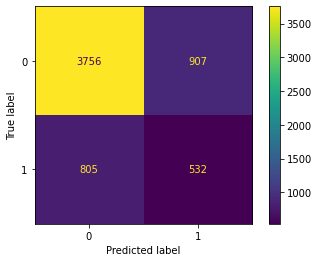

In [ ]:
dec_model = DecisionTreeClassifier()
dec_model.fit(x_train,y_train)
y_pred_dec = dec_model.predict(x_test)
y_pred_dec_train = dec_model.predict(x_train)
res(y_pred_dec,y_pred_dec_train)

### Hyper parameter tuning for DecisionTree

In [ ]:
parameters = {'max_depth':[1,2,3,4,5,6],'min_samples_split':[3,4,5,6,7],'min_samples_leaf':[1,2,3,4,5,6]}
tree = GridSearchCV(dec_model, parameters,cv=10)
tree.fit(x_train,y_train)
tree.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4663
           1       0.68      0.35      0.46      1337

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.79      6000

train_accuracy: 0.824375
test_accuracy: 0.8183333333333334


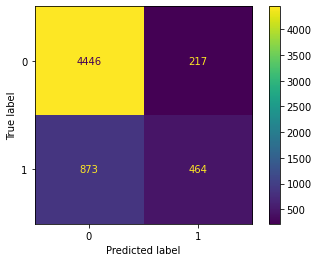

In [ ]:
# We know that Decision tree will have high variance due to which the model overfit hence we can reduce this by "Pruning"
# By using the best parameter from GridSearchCV best parameters
dec_model1 = DecisionTreeClassifier(max_depth=4,min_samples_split=10,min_samples_leaf=1)
dec_model1.fit(x_train,y_train)
y_pred_dec1 = dec_model1.predict(x_test)
y_pred_dec_train1 = dec_model1.predict(x_train)
res(y_pred_dec1,y_pred_dec_train1)

# Random Forest Model

In [22]:
rf_model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='log2', max_depth=15, random_state=42)
rf_model.fit(x_train,y_train)
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
#res(y_pred_rf,y_pred_rf_train)

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[6647  353]
 [1282  718]]


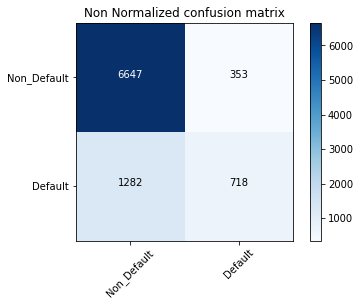

In [25]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non_Default','Default'], normalize=False,
                      title='Non Normalized confusion matrix')

In [26]:
from sklearn.metrics import recall_score

In [27]:
print("Recall score:"+ str(recall_score(y_test, y_pred_rf)))

Recall score:0.359


### Again hyper parameter tuning for Random Forest

In [28]:
parameters = {'n_estimators':[60,70,80],'max_depth':[1,2,3,4,5,6],'min_samples_split':[3,4,5,6,7],
               'min_samples_leaf':[1,2,3,4,5,6]}
clf = GridSearchCV(rf_model, parameters,cv=10)
clf.fit(x_train,y_train)
clf.best_params_
#  {'max_depth': 5,
#   'min_samples_leaf': 4,
#   'min_samples_split': 3,
#   'n_estimators': 70}

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 80}

Confusion matrix, without normalization
[[6679  321]
 [1306  694]]


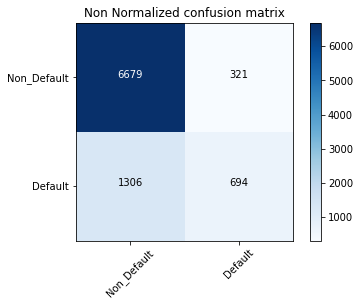

In [29]:
# Decision trees frequently perform well on imbalanced data. so using RandomForest uses bagging of n_trees will be a better idea.
rf_model = RandomForestClassifier(n_estimators=80, max_depth=6, min_samples_leaf=2, min_samples_split=5)
rf_model.fit(x_train,y_train)
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
#res(y_pred_rf,y_pred_rf_train)

cnf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non_Default','Default'], normalize=False,
                      title='Non Normalized confusion matrix')

In [30]:
print("Recall score:"+ str(recall_score(y_test, y_pred_rf)))

Recall score:0.347


# KNN model

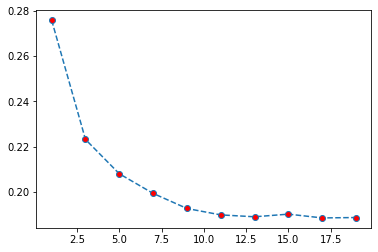

In [ ]:
# finding the K value
error = []

for i in range(1,21,2):
    knn =  KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    preds = knn.predict(x_test)
    error.append(np.mean(preds!=y_test))

plt.plot(range(1,21,2), error, linestyle = 'dashed', marker ='o', mfc= 'red')

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4663
           1       0.55      0.34      0.42      1337

    accuracy                           0.79      6000
   macro avg       0.69      0.63      0.65      6000
weighted avg       0.77      0.79      0.77      6000

train_accuracy: 0.84325
test_accuracy: 0.792


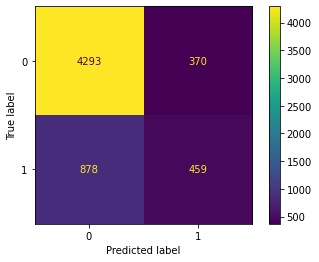

In [ ]:
# By using the elbow graph we can see that the k=5 will perform better in the first place so impute k = 5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train,y_train)
y_pred_knn = knn_model.predict(x_test)
y_pred_knn_train = knn_model.predict(x_train)

res(y_pred_knn,y_pred_knn_train)

# SVM Model

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4663
           1       0.49      0.56      0.52      1337

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000

train_accuracy: 0.7889583333333333
test_accuracy: 0.7745


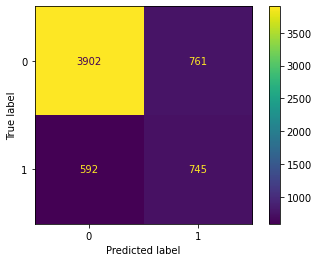

In [ ]:
# use penalized learning algorithms that increase the cost of classification mistakes on the minority class.
svm_model = SVC(class_weight='balanced', probability=True)
svm_model.fit(x_train,y_train)
y_pred_svm = svm_model.predict(x_test)
y_pred_svm_train = svm_model.predict(x_train)
res(y_pred_svm,y_pred_svm_train)

In [ ]:
# we can see in SVM that our recall of target variable is 0.56 which is the best we ever predicted.

# Naive Bayes

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4663
           1       0.45      0.61      0.52      1337

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000

train_accuracy: 0.743375
test_accuracy: 0.7448333333333333


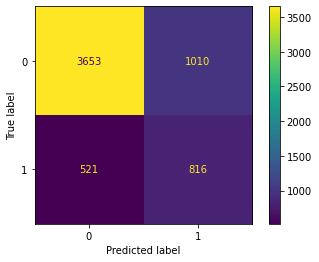

In [ ]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
y_pred_nb = nb_model.predict(x_test)
y_pred_nb_train = nb_model.predict(x_train)
res(y_pred_nb,y_pred_nb_train)

In [ ]:
# But here Naive bayes out performs every other model though over accuracy is acceptable, checkout the recall 

# Boosting model XGB Classifier

[00:09:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4663
           1       0.64      0.35      0.46      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.874125
test_accuracy: 0.8125


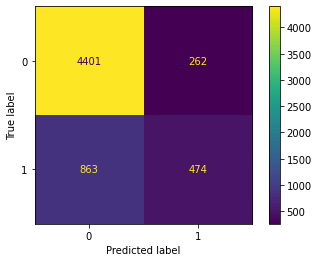

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_y_predict = xgb_model.predict(x_test)
xgb_y_predict_train = xgb_model.predict(x_train)
res(xgb_y_predict,xgb_y_predict_train)

In [ ]:
# Even Boosting technique gives low recall for our target variable

In [ ]:
# So from the above model we can conclude that the data imbalance is playing a major part 
# Hence we try to fix that by doing ReSample techniques

# Random under-sampling
### Let’s apply some of these resampling techniques, using the Python library imbalanced-learn.

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

In [ ]:
x= data2.drop(['def_pay'],1)
y = data2['def_pay']

rus = RandomUnderSampler(random_state=1)
x_rus, y_rus = rus.fit_resample(x,y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({0: 6636, 1: 6636})


In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x_rus,y_rus,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1364
           1       0.78      0.62      0.69      1291

    accuracy                           0.73      2655
   macro avg       0.74      0.73      0.72      2655
weighted avg       0.74      0.73      0.73      2655

train_accuracy: 0.719318074785721
test_accuracy: 0.7295668549905838


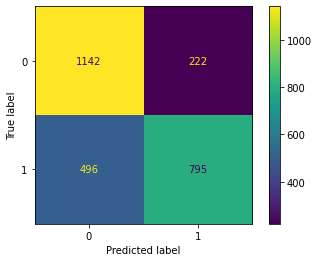

In [ ]:
# again we try to predict using Random Forest
rf_model_rus = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_rus.fit(x_train,y_train)
y_pred_rf_rus = rf_model_rus.predict(x_test)
y_pred_rf_rus_train = rf_model_rus.predict(x_train)
res(y_pred_rf_rus,y_pred_rf_rus_train)

# Random over-sampling

In [ ]:
x= data2.drop(['def_pay'],1)
y = data2['def_pay']

ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({1: 23364, 0: 23364})


In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x_ros,y_ros,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      4607
           1       0.77      0.62      0.69      4739

    accuracy                           0.71      9346
   macro avg       0.72      0.72      0.71      9346
weighted avg       0.72      0.71      0.71      9346

train_accuracy: 0.7182066235086405
test_accuracy: 0.7138882944575219


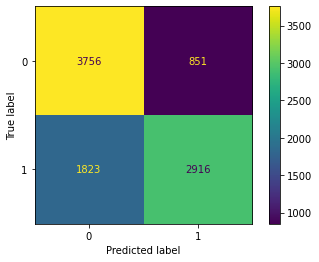

In [ ]:
rf_model_ros = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_ros.fit(x_train,y_train)
y_pred_rf_ros = rf_model_ros.predict(x_test)
y_pred_rf_ros_train = rf_model_ros.predict(x_train)
res(y_pred_rf_ros,y_pred_rf_ros_train)

# Under-sampling: Tomek links

In [ ]:
x= data2.drop(['def_pay'],1)
y = data2['def_pay']

tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(x,y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_tl))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({0: 21479, 1: 6636})


In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x_tl,y_tl,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4286
           1       0.71      0.38      0.49      1337

    accuracy                           0.81      5623
   macro avg       0.77      0.66      0.69      5623
weighted avg       0.80      0.81      0.79      5623

train_accuracy: 0.8188689311755291
test_accuracy: 0.8143339854170372


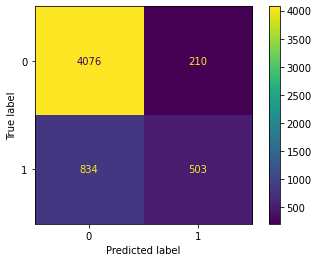

In [ ]:
rf_model_tl = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_tl.fit(x_train,y_train)
y_pred_rf_tl = rf_model_tl.predict(x_test)
y_pred_rf_tl_train = rf_model_tl.predict(x_train)
res(y_pred_rf_tl,y_pred_rf_tl_train)

# Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({1: 23364, 0: 23364})


In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x_smote,y_smote,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      4607
           1       0.87      0.79      0.83      4739

    accuracy                           0.83      9346
   macro avg       0.83      0.83      0.83      9346
weighted avg       0.83      0.83      0.83      9346

train_accuracy: 0.8365256005564176
test_accuracy: 0.831371709822384


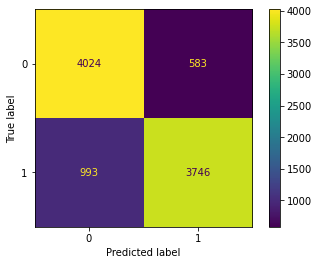

In [ ]:
rf_model_smote = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_smote.fit(x_train,y_train)
y_pred_rf_smote = rf_model_smote.predict(x_test)
y_pred_rf_smote_train = rf_model_smote.predict(x_train)
res(y_pred_rf_smote,y_pred_rf_smote_train)

### Finally using SMOTE we can see our accuracy as well as recall and precision ratio are give equal ratio
### Though all the above models performs well, based on the accuracy  but in a imbalance dataset like this,
####              we actually prefer to change the performance metrics 
### We can get better result when we do SVM and Naive bayes with our original data
### Even we dont have any variance in the model nor to much of bias
### But when we do over or Under sample the date the other metrics like sensity and specificity was better
### Hence we can conclue that if we use resample technique we will get better result